In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
run_no = 1 #'altered'
rundays = 365
runhours = rundays*24

hr_range = pd.date_range('1/1/2016', periods=runhours, freq='H')
day_range = pd.date_range('1/1/2016', periods=rundays, freq='D')

# Annual generation mix

In [3]:
###Observed statistics (EDC, 2016)
gen_obs = [2750, 2570, 411, 792, 158, 38, 0]
indx = ['hydro', 'coal', 'oil','viet', 'thai', 'laos', 'slack']

df_gen_gwh = pd.DataFrame(gen_obs,columns=['obs'])
df_gen_gwh.index = indx
##df_gen_gwh

In [4]:
mwh = pd.read_csv('out_camb_R'+str(run_no)+'_2016_mwh.csv',header=0)
hydro = pd.read_csv('out_camb_R'+str(run_no)+'_2016_hydro.csv',header=0)
hydro_import = pd.read_csv('out_camb_R'+str(run_no)+'_2016_hydro_import.csv',header=0) 

In [5]:
###Include Generator_type to the mwh data
df_gen_param = pd.read_csv('data_camb_genparams.csv',header=0)

gen_name = df_gen_param['name']
gen_type = df_gen_param['typ']

for x in range(len(gen_name)):
    mwh.loc[mwh.Generator == gen_name[x], 'Type'] = gen_type[x]


In [6]:
### Annual generation mix
y_disp = (mwh.groupby(['Type'])['Value'].sum())/1000
y_hydro = sum(hydro['Value'])/1000
y_hydro_import = sum(hydro_import['Value'])/1000

simhydro = y_hydro
simcoal = y_disp['coal_st']
simoil = y_disp['oil_ic'] + y_disp['oil_st']
simviet = y_disp['imp_viet']
simthai = y_disp['imp_thai']
simlaos = y_hydro_import
simslack = y_disp['slack'] 

df_gen_gwh['sim'] = [simhydro,simcoal,simoil,simviet,simthai,simlaos,simslack]

df_gen_gwh

,obs,sim
hydro,2750,2784.532011
coal,2570,2644.672009
oil,411,359.070243
viet,792,796.285118
thai,158,100.332169
laos,38,41.278288
slack,0,0.000000


# Daily generation mix

In [7]:
types = y_disp.index
types

Index(['coal_st', 'imp_thai', 'imp_viet', 'oil_ic', 'oil_st', 'slack'], dtype='object', name='Type')

In [8]:
###Generations by fuel type and time
disp_hourly = mwh.groupby(['Type','Time'])['Value'].sum()

##Hourly TS of dispatchables
ts_disp_hourly = []
for i in range (len(types)):
    ts_disp_hourly.append(pd.Series(disp_hourly[types[i]].values, index=hr_range))


##Daily TS of dispatchables (in GWh)
disp_daily = []
for i in range (len(types)):    
    disp_daily.append(ts_disp_hourly[i].resample('D').sum()/1000)
    
##disp_daily

In [9]:
##Hourly TS of hydro
hydro_hourly = hydro.groupby(['Time'])['Value'].sum()
hydro_import_hourly = hydro_import.groupby(['Time'])['Value'].sum()

ts_hydro = pd.Series(hydro_hourly.values, index=hr_range)
ts_hydro_import = pd.Series(hydro_import_hourly.values, index=hr_range)

##Daily TS of hydro (in GWh)
hydro_daily = ts_hydro.resample('D').sum()/1000
hydro_import_daily = ts_hydro_import.resample('D').sum()/1000

# Plot daily generation mix

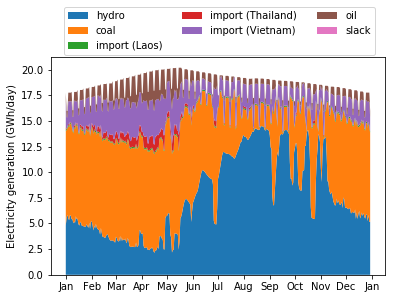

In [10]:
### Plot Daily generation by resource-type
daily_coal = disp_daily[0]
daily_imprt = disp_daily[1] +disp_daily[2] + hydro_import_daily
daily_oil = disp_daily[3] +disp_daily[4]
daily_hydro = hydro_daily
daily_slack = disp_daily[5]

fig, (ax1) = plt.subplots(nrows=1,ncols=1) ##,figsize=(6,4)

ax1.stackplot(day_range,daily_hydro,daily_coal,hydro_import_daily,
              disp_daily[1],disp_daily[2],daily_oil,daily_slack,
              labels=['hydro','coal','import (Laos)','import (Thailand)','import (Vietnam)','oil','slack'])
##ax1.set_xticks(rotation=90)
##ax1.set_xlabel('Day')
ax1.set_ylabel('Electricity generation (GWh/day)')
#ax1.set_ylim(0,20.5)
ax1.legend(loc=(0.04,1.01),ncol=3)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

##plt.savefig('fig_daily_generation_curgrid.eps', format='eps',dpi=1200,bbox_inches = "tight") ##

# Annual operating costs

In [11]:
gen_name = df_gen_param['name']
gen_type = df_gen_param['typ']
gen_maxcap = df_gen_param['maxcap']
gen_heat_rate = df_gen_param['heat_rate']
gen_var_om = df_gen_param['var_om']
gen_fix_om = df_gen_param['fix_om']
gen_st_cost = df_gen_param['st_cost']

In [12]:
###Calibrated fuel_prices (from objective function)
fuel_typ = ['coal_st','oil_ic','oil_st','imp_viet','imp_thai','slack']
cal_fuel_price = [5.2,6.0,6.0,65,66,1000] ##price excluding slack
hydro_imp_price = 48 ##(usd/mwh)

In [13]:
for x in range(len(fuel_typ)):
    df_gen_param.loc[df_gen_param.typ == fuel_typ[x], 'fu_price'] = cal_fuel_price[x]

fu_price = df_gen_param['fu_price']

In [14]:
df_gen_on = pd.read_csv('out_camb_R'+str(run_no)+'_2016_on.csv',header=0)
df_gen_switch = pd.read_csv('out_camb_R'+str(run_no)+'_2016_switch.csv',header=0)

thermo_bygen = (mwh.groupby(['Generator','Time'])['Value'].sum())
on_bygen = (df_gen_on.groupby(['Generator','Time'])['Value'].sum())
switch_bygen = (df_gen_switch.groupby(['Generator','Time'])['Value'].sum())


In [15]:
###Annual total cost by each dispatchable unit
tt_cost_unit = []

for i in range(len(gen_name)):
    fx_cost =  gen_maxcap[i]*gen_fix_om[i]*on_bygen[gen_name[i]]
    st_cost =  gen_maxcap[i]*gen_st_cost[i]*switch_bygen[gen_name[i]]
    vr_cost = thermo_bygen[gen_name[i]]*(gen_heat_rate[i]*fu_price[i]+gen_var_om[i])

    tt_cost = fx_cost + st_cost + vr_cost

    tt_cost_unit.append(sum(tt_cost)) ##total cost by each unit

    
df_tt_cost_unit = pd.DataFrame(tt_cost_unit)
df_tt_cost_unit.index = gen_name
df_tt_cost_unit.columns = ['annual cost ($)']
##df_tt_cost_unit

In [16]:
###Annual cost for hydropower import
cost_hydro_import = sum(hydro_import['Value'])*hydro_imp_price/(10**6) ##million dollars
cost_hydro_import

1.9813578126486455

In [17]:
###Annual total cost for entire system
y_syscost = sum(tt_cost_unit[:-1])/(10**6) + cost_hydro_import ##million dollars excluding slack_cost

y_syscost

243.2553686345892

# Annual CO2 Emissions

In [18]:
###CO2 emission rates according to EPPO/EIA/Mittal
co2_coal_rate = 1.04  ##tonne/mwh
co2_oil_rate = 0.73  ##tonne/mwh

ann_coal_mwh = (simcoal)*(10**3)
ann_oil_mwh = (simoil)*(10**3)

ann_co2_coal = ann_coal_mwh * co2_coal_rate/(10**6) ##in megatonnes
ann_co2_oil = ann_oil_mwh * co2_oil_rate/(10**6) ##in megatonnes

ann_co2_Mtonnes = ann_co2_coal + ann_co2_oil

ann_co2_coal,ann_co2_oil,ann_co2_Mtonnes

(2.7504588891024895, 0.2621212776051299, 3.0125801667076195)